### AB Model from spec

ATTR: _battery_size, _soc_thresh, _loc_init, _soc_init, 
BEH: take_journey, charge_overnight, journey_start (from probability distro), update_soc_theshold

Utility functions

In [1]:
# !pip install seaborn
# !pip install python-statemachine

In [2]:
# imports
import seaborn as sns
from random import choice
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import mesa
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from matplotlib import pyplot as plt, patches
import scipy.stats as ss
import cufflinks as cf
cf.go_offline()
from plotly.offline import iplot
from statemachine import StateMachine, State

In [35]:
class EvStateMachine(StateMachine):
    "A traffic light machine"
    idle = State('Idle', initial=True)
    travelling = State('Travelling')
    in_queue = State('In Queue')
    charging = State('Charging')

    start_travel = idle.to(travelling)
    join_charge_queue = travelling.to(in_queue)
    start_charge = in_queue.to(charging)
    end_charge = charging.to(travelling)
    end_travel = travelling.to(idle)
    def on_start_travel(self):
        # travel()
        print('SM: Travelling')
    def on_join_charge_queue(self):
        # join_charge_queue()
        print('SM: Joining Charge Queue')
    def on_start_charge(self):
        # charge()
        print('SM: Charging')
    def on_end_charge(self):
        # travel()
        print('SM: Travelling')
    def on_end_travel(self):
        # idle()
        print('SM: Idle')
    
class EvState(object):
    def __init__(self, state):
        self.state = state

# make EVstate obj which defaults to idle
obj = EvState(state='idle')
ev_state = EvStateMachine(obj)
# ev_state.is_idle


    # go = red.to(green)
    # def on_slowdown(self):
    #     print('Baba, calm dan')
    # def on_stop(self):
    #     print('hollit')
    # def on_go(self):
    #     print('Movement!')



In [90]:
a = EvStateMachine()
print(a.current_state)
a.start_travel()
print(a.current_state)
# print(a.start_travel())


State('Idle', identifier='idle', value='idle', initial=True, final=False)
SM: Travelling
State('Travelling', identifier='travelling', value='travelling', initial=False, final=False)


In [33]:


# traffic_light = TrafficLightMachine()
# traffic_light.current_state
# traffic_light.current_state == TrafficLightMachine.green == traffic_light.green
# traffic_light.slowdown()

# traffic_light.is_green
# traffic_light.is_yellow
# traffic_light.is_red

# traffic_light.slowdown()
# traffic_light.current_state
# print(traffic_light.current_state)

# [s.identifier for s in traffic_light.states]
# [t.identifier for t in traffic_light.transitions]

# traffic_light.is_yellow
# traffic_light.slowdown()



True

In [2]:
# Config
ticks = 240 # 240 ticks = 10 days
no_cars = 10
no_cpoints = 2


In [3]:
# Method 1
# # distr = ss.norm.rvs(size=1000,loc=12,scale=2, random_state = 42)
# # print(distr[34])
# x = np.arange(1, 25)
# xU, xL = x + 0.5, x - 0.5 
# prob = ss.norm.cdf(xU, scale = 3) - ss.norm.cdf(xL, scale = 3)
# prob = prob / prob.sum() # normalize the probabilities so their sum is 1
# nums = np.random.choice(x, size = 10000, p = prob)
# plt.hist(nums, bins = len(x))

# Method 2
# import numpy as np
# from scipy.stats import truncnorm
# import matplotlib.pyplot as plt

# scale = 3.
# range = 10
# size = 100000

# X = truncnorm(a=-range/scale, b=+range/scale, scale=scale).rvs(size=size)
# X = X.round().astype(int)
# bins = 2 * range + 1
# plt.hist(X, bins)


In [4]:
# generate random numbers from N(0,1) # normal distribution for start time - 5am to 8pm
# type -> array of 1000 elements
# data_normal = ss.norm.rvs(size=1000,loc=12,scale=2, random_state = 42)
# print(data_normal[50])

12.648167938789591


In [40]:
# def get_evs_charged(model):
#     evs_charged = [ev._was_charged for ev in model.evs]
#     no_evs_charged = np.sum(evs_charged)
#     return no_evs_charged

# def get_evs_charge_level(agent):
#     evs_levels = [ev.soc for ev in model.evs]
#     # no_evs_active = np.sum(evs_active)
#     return evs_levels

def get_evs_charge_level(model):
    evs_levels = [ev.soc for ev in model.evs]
    # no_evs_active = np.sum(evs_active)
    return evs_levels

def get_evs_charged(model):
    evs_charged = [ev._was_charged for ev in model.evs]
    no_evs_charged = np.sum(evs_charged)
    return no_evs_charged

def get_evs_active(model):
    evs_active = [ev._is_active for ev in model.evs]
    no_evs_active = np.sum(evs_active)
    return no_evs_active

def get_evs_charging(model):
    evs_charging = [ev._is_charging is True for ev in model.evs]
    no_evs_charging = np.sum(evs_charging)
    return no_evs_charging


In [275]:
a = np.int(ss.uniform(0, 24).rvs(1)) + 1
# np.int(ss.uniform(0, 24).rvs(1) * ticks) + 1
print(a)

17


In [276]:
class ChargingPoint(Agent):
    def __init__(self, unique_id: int, model: Model) -> None:
        super().__init__(unique_id, model)
        self.queue = []
        self._is_charging = True
        self.active_ev = None
        self.entry_time = np.int(ss.uniform(0, 24).rvs(1)) + 1
    def dequeue(self):
        try:
            self.active_ev = self.queue.pop(0)
            self.active_ev._queue_entry = self.model._current_tick
            self.active_ev._queue_exit = self.model._current_tick
        except:
            pass

    def step(self):
        if self.active is None:
            self.dequeue()



In [78]:
class EV(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self._max_battery = 100
        self._soc_usage_thresh = 10
        self.soc_charging_thresh = 70
        # self.soc_charging_thresh = (self._max_battery)/2 # soc level at which EV driver is comfortable with ending charging at station.
        self._charge_rate = 10
        self._in_queue = False
        self._in_garage = False
        self._is_charging = False
        self._was_charged = False
        self._is_travelling = False
        self._journey_complete = False
        #
        self.state = EvStateMachine(start_value = 'idle')
        # self.state = EvStateMachine(obj).current_state
        #
        # self._chargerate = None
        # self._loc_init = 
        # self._soc_init = 50 #initially 50 (+/- 10?). if over multiple days, use learnt value from prev day. If overnight charge, set to 100. write methods to handle cases later.
        # self.queue_time = self.chargerate * self. 
        self.soc = ss.poisson(45).rvs()
        self._pos_init = None #Urgent Fix soon
        self._is_active = True
        self.odometer = 0
        self._distance_goal = None
        self.journey_type = None
        # External 
        self.journey_choice = choice([True, False])
        self.start_time = ss.norm.rvs(size=1000,loc=12,scale=2, random_state = 42)
        # self._cp_entry = None
        # self._cp_exit = None
        # self._charge_start = None
        if self.journey_choice == True:
            self._distance_goal = 50
            self.journey_type = "Urban"
        else:
             self._distance_goal = 100
             self.journey_type = "InterUrban"
        print("EV No " + str(self.unique_id + 1) + " initialized. Journey type: " + str(self.journey_type))
        print(self.state.current_state)


    def travel(self):
        # self._is_travelling = True
        # # self.state.set_state('travelling')
        # self.state
        # self.odometer += 10
        # self.soc -= 5
        # print("Vehicle " + str(self.unique_id + 1 ) + " is currently travelling")
        
        # alt - with sm
        self.state.start_travel()
        self.odometer += 10
        self.soc -= 5
        print("Vehicle " + str(self.unique_id + 1 ) + " is currently travelling")

    # def select_cp(self):
    #     # self._in_queue = True
    #     # # queue at shortest cp
    #     # self._chosen_cp_idx = np.argmin([
    #     #     len(cpoint.queue) for cpoint in self.model.cpoints])
    #     # self._chosen_cp = self.model.cpoint[self._chosen_cpoint_idx]
    #     self._in_queue = True

    
    def charge(self):
        # self._is_charging = True
        # # self._cp_exit = self.model._current_tick
        # # self._chosen_cp.active_car = None
        # # self.soc = self._max_battery
        # # while self.soc < self._max_battery:
        # #     self.soc += self._charge_rate
        # #     if self.soc == self._max_battery:
        # #         self._is_charging = False
        # # if self.soc < self._soc_thresh:
        # self.soc += self._charge_rate
        # # self._is_charging = False
        # self._was_charged = True
        # print("Vehicle " + str(self.unique_id + 1 ) + " charging status: " + str(self._was_charged)+ ". CLevel: " + str(self.soc))
        
        # alt - with sm
        self.state.start_charge()
        self.soc += self._charge_rate
        # self._is_charging = False
        self._was_charged = True
        print("Vehicle " + str(self.unique_id + 1 ) + " charging status: " + str(self._was_charged)+ ". CLevel: " + str(self.soc))
                

    # def charge_overnight(self):
    #     if self._in_garage == True & self.soc < self._max_battery:
    #         # self.soc = self._max_battery
    #         self.soc += self._charge_rate
    #     self._is_charging = True
    #     self._was_charged = True
            
        

    # ////
    def step(self):
        # Block A - state machine:
        if (self.odometer < self._distance_goal) & (self.soc > self._soc_usage_thresh) & (self.state == 'idle'):
            # self.travel()
            print(self.state.state)
            print("Vehicle id: " + str(self.unique_id + 1) + ". This vehicle has travelled: " + str(self.odometer) + " distance units")
            print("Vehicle id: " + str(self.unique_id + 1) + ". This vehicle's current charge level is: " + str(self.soc) + " kwh")
            # a-a if distance_goal not reached,
            if self.odometer == self._distance_goal:
                self._journey_complete == True
                print("Vehicle " + str(self.unique_id + 1) + " has completed its journey")
                self._is_active == False
                self._is_travelling == False
                self._in_garage == True
        #  Block A - another approach
        # a. Once agents have been activated, check odometer and soc, then travel.
        # if (self.odometer < self._distance_goal) & (self.soc > self._soc_usage_thresh):
        #     self.travel()
        #     print("Vehicle id: " + str(self.unique_id + 1) + ". This vehicle has travelled: " + str(self.odometer) + " distance units")
        #     print("Vehicle id: " + str(self.unique_id + 1) + ". This vehicle's current charge level is: " + str(self.soc) + " kwh")
        #     # a-a if distance_goal not reached,
        #     if self.odometer == self._distance_goal:
        #         self._journey_complete == True
        #         print("Vehicle " + str(self.unique_id + 1) + " has completed its journey")
        #         self._is_active == False
        #         self._is_travelling == False
        #         self._in_garage == True
        
        # Block B - state machine

        if (self.odometer < self._distance_goal) & (self.soc <= self._soc_usage_thresh) & (self.state == 'travelling'):
            print("Vehicle " + str(self.unique_id + 1)  + " has hit SOC usage threshold. Heading to charging station")
            self.charge()
            self._is_charging = False
            print("Vehicle id: " + str(self.unique_id + 1) + " is charging. This vehicle's current charge level is: " + str(self.soc) + " kwh")
        
        # # Block B - first approach
        # if (self.odometer < self._distance_goal) & (self.soc <= self._soc_usage_thresh) & (self._is_travelling == True):
        #     print("Vehicle " + str(self.unique_id + 1)  + " has hit SOC usage threshold. Heading to charging station")
        #     # self._is_travelling == False
        #     # self._is_active = False
        #     # self.charge() #charge
        #     # if self.soc > self.soc_charging_thresh:
        #     #     self._is_charging == False
        #     #     self.travel()
        #     # else:
        #     #     self.charge()

        #     self.charge()
        #     self._is_charging = False
        #     print("Vehicle id: " + str(self.unique_id + 1) + " is charging. This vehicle's current charge level is: " + str(self.soc) + " kwh")
        #     # if (self.soc < self.soc_charging_thresh):
        #     # # if (self.soc < self.soc_charging_thresh) & (self._is_charging == True):
        #     #     self.charge()
        #     #     print("Vehicle id: " + str(self.unique_id + 1) + " is still charging. This vehicle's current charge level is: " + str(self.soc) + " kwh")
        # # else:
        # #     self.travel()
        # # if (self.odometer < self._distance_goal) & (self.soc <= self._soc_usage_thresh) & (self._is_travelling == True) & (self.soc <self.soc_charging_thresh)x
                
class EVModel(Model):
    """Simulation Model with EV agents."""

    def __init__(self, no_evs, ticks):
        # super().__init__()
        # init with input args
        self.ticks = ticks
        self._current_tick = 1
        self.no_evs = no_evs
        # other key model attr 
        self.schedule = RandomActivation(self)
        # Populate model with agents
        self.evs = []
        for i in range(self.no_evs):
            ev = EV(i,self)
            self.schedule.add(ev)
            self.evs.append(ev)
        self.datacollector = DataCollector(
            model_reporters={'EVs Charged': get_evs_charged,
                             'EVs Activated': get_evs_active,
                             'EVs Charge Level': get_evs_charge_level,
                             'EVs Currently charging': get_evs_charging,}
            )
    
    def step(self):
        """Advance model one step in time"""
        self.datacollector.collect(self)
        self.schedule.step()
        self._current_tick += 1

In [72]:
ticks = 24 # 3600 ticks = 3600 seconds = 1 hour
no_evs = 1


In [80]:
# no_cpoints = 2
model = EVModel(ticks=ticks, no_evs=no_evs)
for i in range(ticks):
    # print(len(model.evs))
    model.step()
model.datacollector.get_model_vars_dataframe()


EV No 1 initialized. Journey type: InterUrban


AttributeError: 'State' object has no attribute 'current_state'

In [82]:
a = EV(0, model)

EV No 1 initialized. Journey type: Urban


AttributeError: 'State' object has no attribute 'current_state'

In [251]:
# # model.datacollector.get_agent_vars_dataframe()
# model.datacollector.get_model_vars_dataframe()


In [5]:
# class Car(Agent):
#     """
#     Attr:

#     Flags:
    
    
#     """
#     def __init__(self, unique_id, model):
#         super().__init__(unique_id, model)
#         self._max_battery = 100
#         self._soc_thresh = 10
#         self._charge_rate = 20 #Vehicle soc rises at 20 per tick
#         self._in_queue = False
#         self._in_garage = False
#         self._is_charging = False
#         self._was_charged = False
#         self._is_travelling = False
#         self._journey_complete = False

#         # self._chargerate = None
#         # self._loc_init = 
#         # self._soc_init = 50 #initially 50 (+/- 10?). if over multiple days, use learnt value from prev day. If overnight charge, set to 100. write methods to handle cases later.
#         # self.queue_time = self.chargerate * self. 
#         self.soc = ss.poisson(45).rvs()
#         self._pos_init = None #Urgent Fix soon
#         self._is_active = False
#         self.odometer = 0
#         self._distance_goal = 0
#         self.journey_type = None
#         # External 
#         self.journey_choice = choice([True, False])
#         self.start_time = ss.norm.rvs(size=1000,loc=12,scale=2, random_state = 42)
#         # self.select_journey_type()
#         # self._cp_entry = None
#         # self._cp_exit = None
#         # self._charge_start = None

#     def select_journey_type(self):
#         self._is_active == True
#         if self.journey_choice == True:
#             self._distance_goal = 50
#             self.journey_type = "Urban"
#         else:
#              self._distance_goal = 100
#              self.journey_type = "InterUrban"

#         # print("Journey type selected: " + str(self._distance_goal))


#     def travel(self):
#         self._is_travelling = True
#         self.odometer += 10
#         self.soc -= 5
#         # if self._is_travelling == True & self._is_active == True:
#         if self._is_travelling == True:
#             print("This car's id is: " + str(self.unique_id) + " and it's going on an " + str(self.journey_type) + " journey" + " with a distance goal of " 
#             + str(self._distance_goal))


#     # def select_cp(self):
#     #     # self._in_queue = True
#     #     # # queue at shortest cp
#     #     # self._chosen_cp_idx = np.argmin([
#     #     #     len(cpoint.queue) for cpoint in self.model.cpoints])
#     #     # self._chosen_cp = self.model.cpoint[self._chosen_cpoint_idx]
#     #     self._in_queue = True

    
#     def charge(self):
#         self._is_charging = True
#         # self._cp_exit = self.model._current_tick
#         # self._chosen_cp.active_car = None
#         # self.soc = self._max_battery
#         # while self.soc < self._max_battery:
#         #     self.soc += self._charge_rate
#         #     if self.soc == self._max_battery:
#         #         self._is_charging = False
#         if self.soc < self._max_battery:
#             self.soc += self._charge_rate
#             print("Vehicle " + str(self.unique_id) + " is charging")
#         if self.soc == self._max_battery:
#             print("Vehicle charged")
#         self._is_charging = False
#         self._was_charged = True
                

#     def charge_overnight(self):
#         if self._in_garage == True:
#             self.soc = self._max_battery
    
#     # def step(self):
#     #     if (self._in_queue == False) & (self.model._current_tick >= self.entry_time):
#     #         self.select_cp()
#     #     elif isinstance(self.self._cp_entry, int):
#     #         if self.model._current_tick - self._cp_entry == self.charge_time:
#     #             self.travel()
#     def step(self):
#         # while (self.odometer < self._distance_goal) & self.soc > self._soc_thresh: # didnt work. 
#         if (self.odometer < self._distance_goal):
#             self.travel()
#             print("Vehicle id: " + str(self.unique_id) + ". This vehicle has travelled: " + str(self.odometer) + " distance units")
#             print("Vehicle id: " + str(self.unique_id) + ". This vehicle's current charge level is: " + str(self.soc) + " kwh")
#             if self.odometer == self._distance_goal:
#                 self._journey_complete == True
#                 print("Vehicle " + str(self.unique_id) + " has completed its journey")
#                 # self._is_active == False
#                 # self._is_travelling == False

#         if self.soc < self._soc_thresh & (self._journey_complete == False):
#             self._is_travelling == False
#             print("Vehicle has hit SOC threshold. Heading to charging station")
#             # self._is_charging == True
#             self.charge() #charge
#             self.travel()
            




# class MainModel(Model):
#     """Simulation Model with cars and charging points as two types of agents, interacting."""

#     def __init__(self, no_cars, ticks):
#         # super().__init__()
#         # init with input args
#         self.ticks = ticks
#         self._current_tick = 1
#         self.no_cars = no_cars
#         # other key model attr 
#         self.schedule = RandomActivation(self)
#         # Populate model with agents
#         self.cars = []
#         for i in range(self.no_cars):
#             car = Car(i,self)
#             self.schedule.add(car)

#         self.datacollector = DataCollector(
#             model_reporters={'Cars Charged': get_cars_charged,
#                              'Cars Activated': get_cars_active})
    
#     def step(self):
#         self.datacollector.collect(self)
#         self.schedule.step()
#         self._current_tick += 1



In [11]:
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer

def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "Layer": 0,
                 "Color": "red",
                 "r": 0.5}
    return portrayal

grid = CanvasGrid(agent_portrayal, 10, 10, 500, 500)
server = ModularServer(Model,
                       [grid],
                       "My Model",
                       {'n_agents': 10})
server.launch()

Interface starting at http://127.0.0.1:8521


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}


ERROR:tornado.application:Uncaught exception GET /ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='127.0.0.1:8521', method='GET', uri='/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/Users/isaacao/Library/Python/3.9/lib/python/site-packages/tornado/websocket.py", line 635, in _run_callback
    result = callback(*args, **kwargs)
  File "/Users/isaacao/Library/Python/3.9/lib/python/site-packages/mesa/visualization/ModularVisualization.py", line 238, in on_message
    self.write_message(self.viz_state_message)
  File "/Users/isaacao/Library/Python/3.9/lib/python/site-packages/mesa/visualization/ModularVisualization.py", line 221, in viz_state_message
    return {"type": "viz_state", "data": self.application.render_model()}
  File "/Users/isaacao/Library/Python/3.9/lib/python/site-packages/mesa/visualization/ModularVisualization.py", line 396, in render_model
    element_state = element.render(self.model)
  File "/Users/isaacao/Library/Py

NameError: name 'no_counters' is not defined

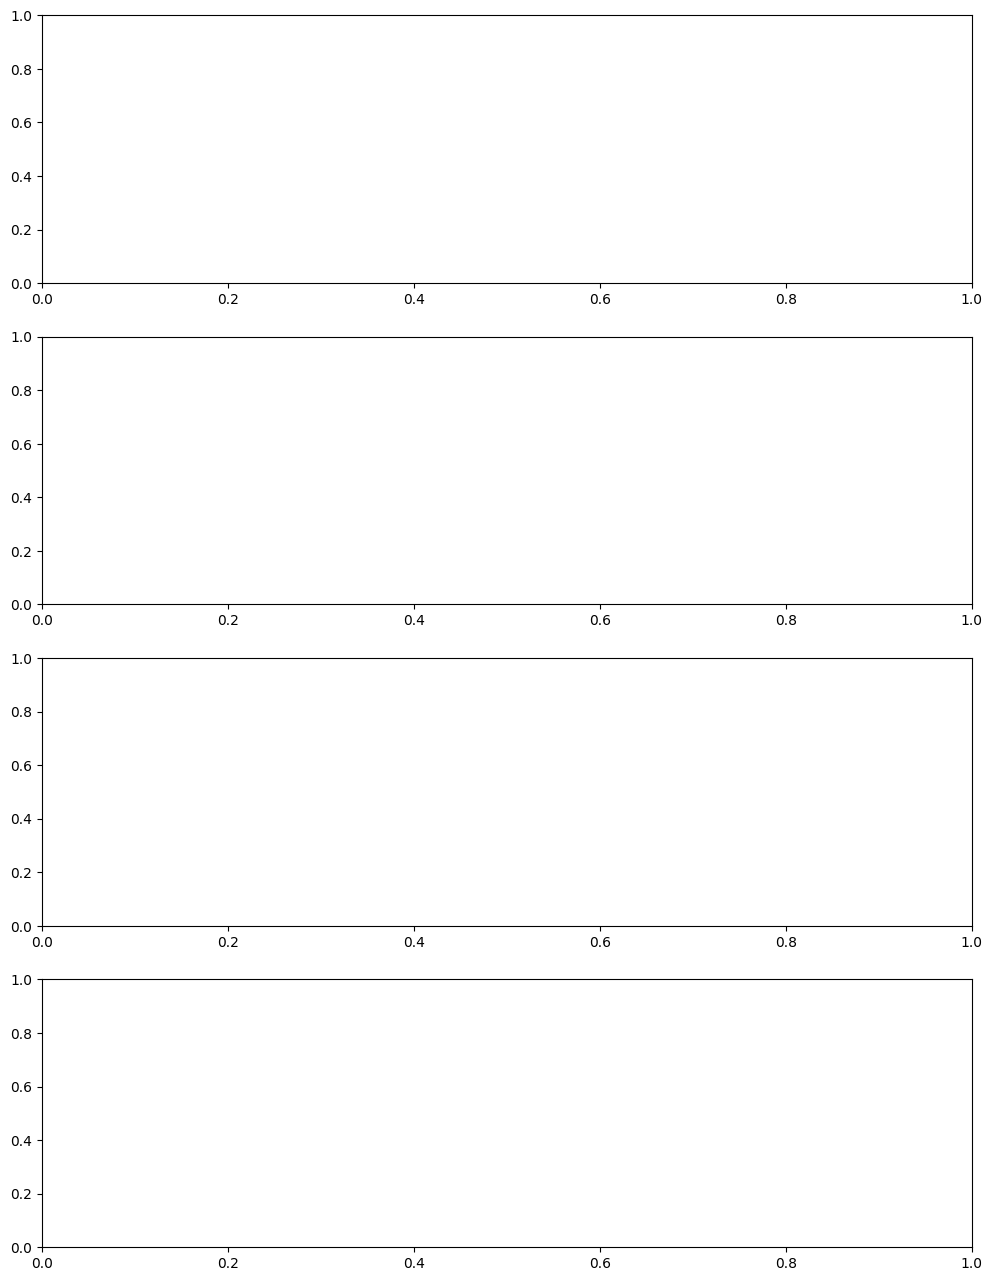

In [12]:
run_stats = model.datacollector.get_model_vars_dataframe()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(2, 1)
fig.figure.set_figwidth(12)
fig.figure.set_figheight(16)
fig.suptitle(f'Simulations stats using {no_cars} cars', fontsize=20)
ax1.plot(run_stats[['Cars Activated',
                'Cars Charged',
               ]])
ax1.legend(['Cars Activated',
            'Cars Charged',
            'Customers Balked',
            ])
ax1.set_ylabel('Customers')
ax1.set_xlim(0)
ax1.set_ylim(0)
ax2.plot(run_stats['Average Queue Size'], color='red')
ax2.legend(['Average Queue Size'])
ax2.set_ylabel('Customers')
ax2.set_xlim(0)
ax2.set_ylim(0)
ax3.plot(run_stats['Average Waiting Time'], color='grey')
ax3.legend(['Average Waiting Time (across full hour)'])
ax3.set_ylabel('Seconds')
ax3.set_xlim(0)
ax3.set_ylim(0)
ax4.plot(run_stats[['Gross Margin',
                'Operating Costs',
                'Total Profit'
               ]])
ax4.legend(['Gross Margin',
            'Operating Costs',
            'Total Profit'
            ])
ax4.set_ylabel('Dollars')
ax4.set_xlim(0)
fig.show()

### Scrapbook

In [ ]:
# initial approach to EV agent step method
    # approach works, little quirks. control flow faulty. does not allow for stepwise charging
    
    # if self.model._current_tick >= self.start_time:
    # while (self.odometer < self._distance_goal) & self.soc > self._soc_thresh: # didnt work. 
    # self.select_journey_type()
    # if self.odometer < self._distance_goal:
    #     self.travel()
    #     print("Vehicle id: " + str(self.unique_id + 1) + ". This vehicle travelled: " + str(self.odometer) + " distance units")
    #     print("Vehicle id: " + str(self.unique_id + 1) + ". This vehicle's current charge level is: " + str(self.soc) + " kwh")
    #     if self.odometer == self._distance_goal:
    #         self._journey_complete == True
    #         print("Vehicle " + str(self.unique_id + 1) + " has completed its journey")
    #         self._is_active == False
    #         self._is_travelling == False
    #         self._in_garage == True

    # if (self.soc < self._soc_thresh) & (self._is_travelling == True):
    #     self._is_travelling == False
    #     print("Vehicle "+ str(self.unique_id + 1)  + " has hit SOC threshold. Heading to charging station")
    #     self._is_charging == True
    #     self.charge() #charge
    #     self.travel()
            

In [ ]:
# from travel

        # print("Vehicle id: " + str(self.unique_id) + ". This vehicle travelled: " + str(self.odometer) + " distance units")
        # print("Vehicle id: " + str(self.unique_id) + ". This vehicle's current charge level is: " + str(self.soc) + " kwh")
            
        # if self.soc < self._soc_thresh:
        #     self._is_travelling == False
        #     self.charge() #charge



In [ ]:
# def get_avg_queue_size(model):
#     queue_size = [len(counter.queue) for counter in model.counters]
#     avg_queue_size = np.mean(queue_size)
#     return avg_queue_size

# def get_avg_waiting_time(model):
#     cars_wait = [np.nan if car._cp_exit is None else
#                       car._cp_exit - car._cp_entry for car in model.cars]
#     avg_customer_wait = np.nanmean(cars_wait)
#     return avg_customer_wait

# def get_customers_served(model):
#     customers_served = [not(customer._service_exit is None) for customer in model.customers]     
#     no_customers_served = np.sum(customers_served)
#     return no_customers_served
# def get_customers_balked(model):
#     customers_arrived = [
#         customer._arrived for customer in model.customers]
#     # Customers who never joined a queue
#     customers_no_q = np.array([
#         customer._q_entry is None for customer in model.customers])
#     no_customers_balked = np.sum(customers_arrived * customers_no_q)
#     return no_customers_balked
# def get_avg_queue_size(model):
#     queue_size = [len(counter.queue) for counter in model.counters]
#     avg_queue_size = np.mean(queue_size)
#     return avg_queue_size
# def get_avg_waiting_time(model):
#     customers_wait = [np.nan if customer._q_exit is None else
#                       customer._q_exit - customer._q_entry for customer in model.customers]
#     avg_customer_wait = np.nanmean(customers_wait)
#     return avg_customer_wait
# def get_gross_margin(model):
#     return gross_margin_per_customer * get_customers_served(model)
# def get_operating_costs(model):
#     return cost_per_counter * no_counters
# def get_total_profit(model):
#     return get_gross_margin(model) - get_operating_costs(model)

In [ ]:
# # ext

# import random

# from mesa import Agent, Model
# from mesa.time import RandomActivation

# class EV(Agent):
#     def __init__(self, unique_id, model):
#         super().__init__(unique_id, model)
#         self.battery = 100 # start with a fully charged battery
#         self.distance_to_travel = random.randint(50, 150) # set random distance to travel

#     def step(self):
#         # if battery is low, go to charging station
#         if self.battery < 20:
#             self.go_to_charging_station()
#         # if there is still distance to travel and the battery is not low, drive
#         elif self.distance_to_travel > 0:
#             self.drive()
#         # if there is no distance left to travel, do nothing
#         else:
#             return

#     def drive(self):
#         self.distance_to_travel -= 1
#         self.battery -= 1

#     def go_to_charging_station(self):
#         self.battery = 100 # fully charge the battery

# class EVModel(Model):
#     def __init__(self, num_evs):
#         self.num_evs = num_evs
#         self.schedule = RandomActivation(self)
#         # create agents
#         for i in range(self.num_evs):
#             ev = EV(i, self)
#             self.schedule.add(ev)


    # def select_journey_type(self):
    #     self._is_active == True
    #     if self.journey_choice == True:
    #         self._distance_goal = 50
    #         self.journey_type = "Urban"
    #     else:
    #          self._distance_goal = 100
    #          self.journey_type = "InterUrban"
    #     if self._is_travelling == True & self._is_active == True:
    #         print("This car's id is: " + str(self.unique_id) + " and it's going on an " + str(self.journey_type) + " journey" + " with a distance goal of " 
    #         + str(self._distance_goal))
    #     # print("Journey type selected: " + str(self._distance_goal))



In [ ]:
    # cpgen
    # def dequeue(self):
    #     if len(self.queue) > 0:
    #         self.active_ev = self.queue.pop(0)
    #         self.active_ev._is_charging = True
    #         self.active_ev._is_active = True
    #         self._is_charging = True
    #         self.active_ev._charge_start_time = self.model.schedule.time
    #         self.active_ev._charge_end_time = self.active_ev._charge_start_time + self.active_ev._charge_duration
    #     else:
    #         self.active_ev = None
    #         self._is_charging = False